# Part 1: Data Setup

In [1]:
# Creating a Spark session
from pyspark.sql import SparkSession
spark = (SparkSession.builder.appName("cs544")
         .master("spark://main:7077")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", "hdfs://main:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/04/04 04:32:50 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Downloading csv files
! wget https://pages.cs.wisc.edu/~harter/cs639/data/hdma-wi-2021.zip
! wget https://pages.cs.wisc.edu/~harter/cs639/data/arid2017_to_lei_xref_csv.zip
! wget https://pages.cs.wisc.edu/~harter/cs639/data/code_sheets.zip

--2023-03-29 23:16:39--  https://pages.cs.wisc.edu/~harter/cs639/data/hdma-wi-2021.zip
Resolving pages.cs.wisc.edu (pages.cs.wisc.edu)... 128.105.7.9
Connecting to pages.cs.wisc.edu (pages.cs.wisc.edu)|128.105.7.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21494278 (20M) [application/zip]
Saving to: ‘hdma-wi-2021.zip’

hdma-wi-2021.zip    100%[===================>]  20.50M  38.2MB/s    in 0.5s    

2023-03-29 23:16:40 (38.2 MB/s) - ‘hdma-wi-2021.zip’ saved [21494278/21494278]

--2023-03-29 23:16:40--  https://pages.cs.wisc.edu/~harter/cs639/data/arid2017_to_lei_xref_csv.zip
Resolving pages.cs.wisc.edu (pages.cs.wisc.edu)... 128.105.7.9
Connecting to pages.cs.wisc.edu (pages.cs.wisc.edu)|128.105.7.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144804 (141K) [application/zip]
Saving to: ‘arid2017_to_lei_xref_csv.zip’

arid2017_to_lei_xre 100%[===================>] 141.41K  --.-KB/s    in 0.1s    

2023-03-29 23:16:40 (1.24 MB/s)

In [3]:
# Unzipping zip files
! unzip hdma-wi-2021.zip
! unzip arid2017_to_lei_xref_csv.zip
! mkdir code_sheets
! unzip code_sheets.zip -d code_sheets

Archive:  hdma-wi-2021.zip
  inflating: hdma-wi-2021.csv        
Archive:  arid2017_to_lei_xref_csv.zip
  inflating: arid2017_to_lei_xref_csv.csv  
Archive:  code_sheets.zip
  inflating: code_sheets/action_taken.csv  
  inflating: code_sheets/agency.csv  
  inflating: code_sheets/counties.csv  
  inflating: code_sheets/denial_reason.csv  
  inflating: code_sheets/edit_status.csv  
  inflating: code_sheets/ethnicity.csv  
  inflating: code_sheets/hoepa.csv   
  inflating: code_sheets/lien_status.csv  
  inflating: code_sheets/loan_purpose.csv  
  inflating: code_sheets/loan_type.csv  
  inflating: code_sheets/msamd.csv   
  inflating: code_sheets/owner_occupancy.csv  
  inflating: code_sheets/preapproval.csv  
  inflating: code_sheets/property_type.csv  
  inflating: code_sheets/purchaser_type.csv  
  inflating: code_sheets/race.csv    
  inflating: code_sheets/sex.csv     
  inflating: code_sheets/states.csv  
  inflating: code_sheets/tracts.csv  


In [2]:
# Uploading csv files to HDFS
! hdfs dfs -cp hdma-wi-2021.csv hdfs://main:9000/hdma-wi-2021.csv
! hdfs dfs -cp arid2017_to_lei_xref_csv.csv hdfs://main:9000/arid2017_to_lei_xref_csv.csv
! hdfs dfs -cp code_sheets/* hdfs://main:9000/

In [4]:
# Loading data into Spark
import os

(spark.read.csv(f"hdfs://main:9000/hdma-wi-2021.csv", header=True, inferSchema=True)
 .write.bucketBy(8, "county_code")
 .saveAsTable("loans", mode="overwrite"))

(spark.read.csv(f"hdfs://main:9000/arid2017_to_lei_xref_csv.csv", header=True, inferSchema=True)
 .write
 .saveAsTable("banks", mode="overwrite"))

for file in os.scandir("code_sheets/"):
    if "csv" in file.name:
        name = file.name
        split_name = file.name.split(".")[0]
        (spark.read.format("csv")
         .option("header", True)
         .option("inferSchema", True)
         .load("hdfs://main:9000/{}".format(name))
         .createOrReplaceTempView("{}".format(split_name)))

## Q1: what tables are in our warehouse?

In [5]:
spark.sql("SHOW TABLES").show()

+---------+-------------+-----------+
|namespace|    tableName|isTemporary|
+---------+-------------+-----------+
|  default|        banks|      false|
|  default|        loans|      false|
|         | action_taken|       true|
|         |     counties|       true|
|         |denial_reason|       true|
|         |    ethnicity|       true|
|         | loan_purpose|       true|
|         |    loan_type|       true|
|         |  preapproval|       true|
|         |property_type|       true|
|         |         race|       true|
|         |          sex|       true|
|         |       states|       true|
|         |       tracts|       true|
+---------+-------------+-----------+



# Part 2: Filter and Join

## Q2: how many banks contain the word "first" in their name? Which ones contain "second"?

In [6]:
first = spark.sql("""
SELECT COUNT(*) as first_count
FROM banks
WHERE LOWER(respondent_name) LIKE '%first%'
""").toPandas()

print(first)
spark.sql("""
SELECT *
FROM banks
WHERE LOWER(respondent_name) LIKE '%second%'
""").toPandas()

   first_count
0          525


,respondent_name,arid_2017,lei_2018,lei_2019,lei_2020
0,Old Second National Bank,14596,B94HV8SXGDD3J5XESU08,B94HV8SXGDD3J5XESU08,B94HV8SXGDD3J5XESU08


## Q3: how many loan applications has your "favorite" bank received in the dataset?

In [7]:
results = spark.sql("""
SELECT COUNT(*)
FROM banks
INNER JOIN loans
ON banks.lei_2018 = loans.lei
WHERE respondent_name = 'Bank of America, National Association'
""")
results.toPandas()

,count(1)
0,934


## Q4: what does results.explain("formatted") tell us about Spark's query plan for Q3?

In [7]:
results.explain("formatted")

# 1. The loans table is sent to every executor via a BroadcastExchange Operation
# 2. "is not null" filtering is added by the optimizer to the banks and loans tables.
# 3. Yes, the plan involves HashAggregate(s). There are two partial_count(s) and two regular counts.

== Physical Plan ==
AdaptiveSparkPlan (25)
+- == Final Plan ==
   * HashAggregate (15)
   +- ShuffleQueryStage (14)
      +- Exchange (13)
         +- * HashAggregate (12)
            +- * Project (11)
               +- * BroadcastHashJoin Inner BuildLeft (10)
                  :- BroadcastQueryStage (6)
                  :  +- BroadcastExchange (5)
                  :     +- * Project (4)
                  :        +- * Filter (3)
                  :           +- * ColumnarToRow (2)
                  :              +- Scan parquet default.banks (1)
                  +- * Filter (9)
                     +- * ColumnarToRow (8)
                        +- Scan parquet default.loans (7)
+- == Initial Plan ==
   HashAggregate (24)
   +- Exchange (23)
      +- HashAggregate (22)
         +- Project (21)
            +- BroadcastHashJoin Inner BuildLeft (20)
               :- BroadcastExchange (18)
               :  +- Project (17)
               :     +- Filter (16)
               :        +-

## Q5: what are the top 10 biggest loans (in terms of loan_amount) that were approved by your favorite bank?

In [8]:
spark.sql("""
SELECT census_tract, counties.name as county, purpose.loan_purpose, derived_dwelling_category, (loan_amount /1000) as thousands, interest_rate, (loan_term / 12) as years, actions.action_taken
FROM
(
    SELECT SUBSTRING(county_code, 1, 2) as state, SUBSTRING(county_code, 3, LENGTH(county_code)) as county, *
    FROM banks
    INNER JOIN loans
    ON banks.lei_2018 = loans.lei
    WHERE respondent_name = 'Bank of America, National Association'
) as boa
INNER JOIN action_taken as actions
ON boa.action_taken = actions.id
INNER JOIN counties
ON boa.state = counties.state
AND boa.county = counties.county
LEFT JOIN loan_purpose as purpose
ON boa.loan_purpose = purpose.id 
WHERE actions.action_taken = 'Loan originated'
ORDER BY boa.loan_amount DESC
LIMIT 10
""").toPandas() 

,census_tract,county,loan_purpose,derived_dwelling_category,thousands,interest_rate,years,action_taken
0,55133204100,Waukesha,None,Single Family (1-4 Units):Site-Built,4005.0,2.375,15.0,Loan originated
1,55047100400,Green Lake,None,Single Family (1-4 Units):Site-Built,2135.0,2.125,30.0,Loan originated
2,55127001602,Walworth,None,Single Family (1-4 Units):Site-Built,2005.0,2.375,30.0,Loan originated
3,55025001804,Dane,Home purchase,Single Family (1-4 Units):Site-Built,1565.0,1.875,30.0,Loan originated
4,55127000302,Walworth,None,Single Family (1-4 Units):Site-Built,1505.0,2.125,15.0,Loan originated
5,55127000302,Walworth,Home purchase,Single Family (1-4 Units):Site-Built,1445.0,2.375,30.0,Loan originated
6,55127001604,Walworth,None,Single Family (1-4 Units):Site-Built,1335.0,2.25,30.0,Loan originated
7,55127000800,Walworth,None,Single Family (1-4 Units):Site-Built,1305.0,2.75,15.0,Loan originated
8,55009021301,Brown,None,Single Family (1-4 Units):Site-Built,1215.0,2.125,30.0,Loan originated
9,55101002402,Racine,None,Single Family (1-4 Units):Site-Built,1105.0,2.0,30.0,Loan originated


# Part 3: GROUPY BY and Windowing

## Q6: when computing a MEAN aggregate per group of loans, when do we require network I/O between the partial_mean and mean operations?

In [9]:
res1 = spark.sql("""
SELECT AVG(tract_population), county_code
FROM loans
GROUP BY county_code
""")

res2 = spark.sql("""
SELECT AVG(tract_population), lei
FROM loans
GROUP BY lei
""")

res1.explain("formatted")
res2.explain("formatted")

# A network transfer is unnecessary for the first query and necessary for the second query because when we loaded the loans table earlier, 
# we bucketed by the county_code column. Thus, when we grouped by the county_code, a network transfer is unnecessary because
# the data is pre-partitioned. 

== Physical Plan ==
AdaptiveSparkPlan (4)
+- HashAggregate (3)
   +- HashAggregate (2)
      +- Scan parquet default.loans (1)


(1) Scan parquet default.loans
Output [2]: [county_code#967, tract_population#1055]
Batched: true
Location: InMemoryFileIndex [hdfs://main:9000/user/hive/warehouse/loans]
ReadSchema: struct<county_code:string,tract_population:int>
SelectedBucketsCount: 8 out of 8

(2) HashAggregate
Input [2]: [county_code#967, tract_population#1055]
Keys [1]: [county_code#967]
Functions [1]: [partial_avg(tract_population#1055)]
Aggregate Attributes [2]: [sum#1199, count#1200L]
Results [3]: [county_code#967, sum#1201, count#1202L]

(3) HashAggregate
Input [3]: [county_code#967, sum#1201, count#1202L]
Keys [1]: [county_code#967]
Functions [1]: [avg(tract_population#1055)]
Aggregate Attributes [1]: [avg(tract_population#1055)#1191]
Results [2]: [avg(tract_population#1055)#1191 AS avg(tract_population)#1192, county_code#967]

(4) AdaptiveSparkPlan
Output [2]: [avg(tract_populatio

## Q7: what are the average interest rates for Wells Fargo applications for the ten counties where Wells Fargo receives the most applications?

<Axes: xlabel='name', ylabel='Average Interest Rate'>

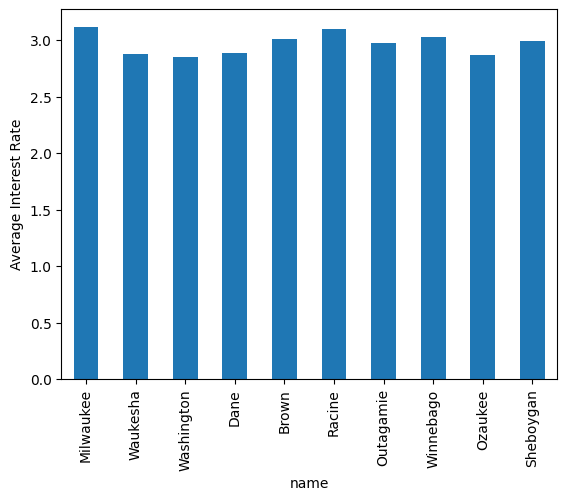

In [9]:
avg_df = spark.sql("""
SELECT counties.name, AVG(wells.interest_rate) as avg_interest_rate, COUNT(*) as count
FROM
(
    SELECT SUBSTRING(county_code, 1, 2) as state, SUBSTRING(county_code, 3, LENGTH(county_code)) as county, loans.interest_rate
    FROM banks
    INNER JOIN loans
    ON banks.lei_2018 = loans.lei
    WHERE respondent_name = 'Wells Fargo Bank, National Association'
) as wells
INNER JOIN counties
ON wells.state = counties.state
AND wells.county = counties.county
GROUP BY counties.name
ORDER BY count DESC
LIMIT 10
""").toPandas()
avg_df.plot.bar(x='name', y='avg_interest_rate', legend=False, ylabel="Average Interest Rate")

## Q8: what is the second biggest loan application amount in each county? (answer for top 10 counties).

<Axes: xlabel='name', ylabel='2nd Biggest Loan Application (Millions $)'>

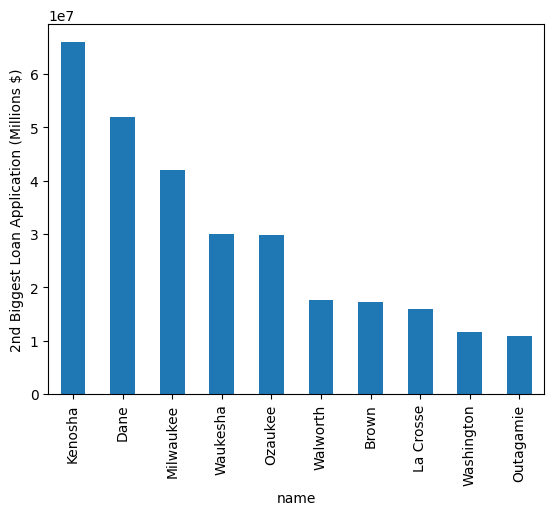

In [11]:
df = spark.sql("""
SELECT counties.name, loan_amount
FROM
(
    SELECT SUBSTRING(county_code, 1, 2) as state, SUBSTRING(county_code, 3, LENGTH(county_code)) as county, loans.loan_amount
    FROM loans
) as new_loans
INNER JOIN counties
ON new_loans.state = counties.state
AND new_loans.county = counties.county
GROUP BY counties.name, loan_amount
""")
df.createOrReplaceTempView("df")

second_biggest = spark.sql("""
SELECT *, row_number() OVER (PARTITION BY name ORDER BY loan_amount DESC) AS num
FROM df
ORDER BY loan_amount DESC
""").where("num = 2").limit(10).toPandas()

second_biggest.plot.bar(x='name', y='loan_amount', ylabel="2nd Biggest Loan Application (Millions $)", legend=False)

# Part 4: Caching

## Q9: what is the cost of caching and the impact on subsequent queries?

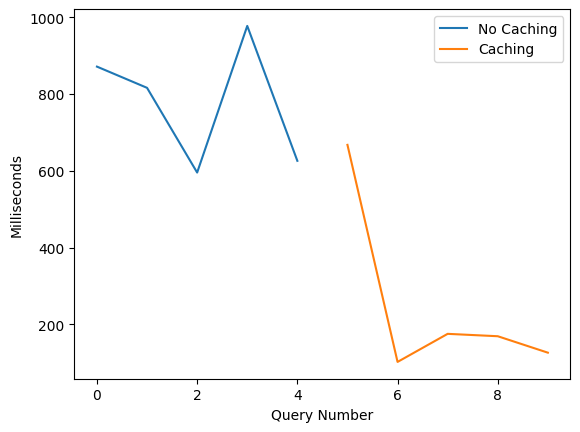

In [24]:
import time
from matplotlib import pyplot as plt

latencies = []

df1 = spark.sql("""
SELECT interest_rate
FROM banks
INNER JOIN loans
ON banks.lei_2020 = loans.lei 
WHERE banks.respondent_name = 'Wells Fargo Bank, National Association'
""")

for i in range(10):
    if i == 5:
        df1.cache()
    start = time.time()
    df1.count()
    end = time.time()
    latency = (end - start) * 1000
    latencies.append(latency)

no_caching = latencies[:len(latencies) // 2]
caching = latencies[len(latencies) // 2:]

plt.plot([0, 1, 2, 3, 4], no_caching, label="No Caching")
plt.plot([5, 6, 7, 8, 9], caching, label="Caching")
plt.xlabel("Query Number")
plt.ylabel("Milliseconds")
plt.legend()
plt.show()

## Q10: what is the impact of caching a single partition on load balance?

23/04/04 04:47:39 WARN CacheManager: Asked to cache already cached data.


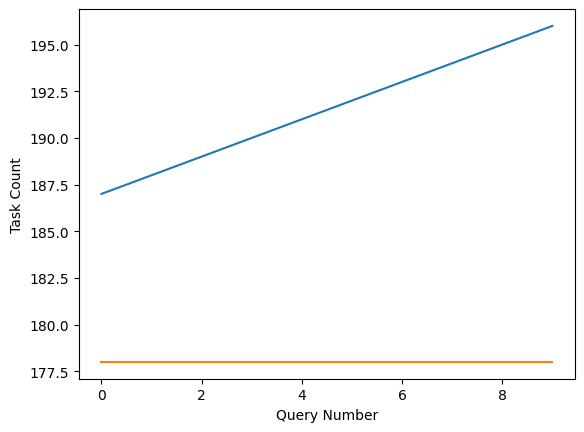

In [25]:
import requests

executor1 = []
executor2 = []

df1 = df1.repartition(1)
df1.cache()

for i in range(10):
    df1.count()
    r = requests.get("http://localhost:4040/api/v1/applications")
    r.raise_for_status()
    app_id = r.json()[0]["id"]
    r = requests.get("http://localhost:4040/api/v1/applications/{}/executors".format(app_id))
    r.raise_for_status()
    totalTasks1 = r.json()[1]["totalTasks"]
    executor1.append(totalTasks1)
    totalTasks2 = r.json()[2]["totalTasks"]
    executor2.append(totalTasks2)
    
plt.plot([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], executor1)
plt.plot([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], executor2)
plt.xlabel("Query Number")
plt.ylabel("Task Count")
plt.show()